<a href="https://colab.research.google.com/github/NiyatiGohel/Multimodal-Vision-Language-AI-System/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Image Captioning

In [ ]:
!pip install torch transformers accelerate bitsandbytes datasets evaluate rouge_score matplotlib seaborn wordcloud


In [ ]:
import os
import zipfile
import shutil
from google.colab import drive

# 1. Mount Google Drive
print("Mounting Google Drive")
drive.mount('/content/drive')

# 2. Define Paths
# Assuming you uploaded 'archive(14).zip' to the main folder of your Google Drive
drive_path = "/content/drive/MyDrive/archive (14).zip"
local_zip = "archive(14).zip"
extract_path = "flickr30k_local"

if os.path.exists(drive_path):
    print(f"Found file in Drive: {drive_path}")
    print("Copying to local runtime")
    shutil.copy(drive_path, local_zip)
else:
    print(f"Error: Could not find '{drive_path}' in your Google Drive.")
    print("Need to upload 'archive (14).zip' to the root of Google Drive.") # Updated message
    # Stop here if file not found
    raise FileNotFoundError("File not found in Drive")

# 4. Extract
print(f"Extracting to '{extract_path}/'")
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

try:
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction Complete!")

    # Verify structure
    print("\nDirectory contents:")
    print(os.listdir(extract_path)[:5])

except zipfile.BadZipFile:
    print("Error: The zip file appears to be corrupted.")

Mounting Google Drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found file in Drive: /content/drive/MyDrive/archive (14).zip
Copying to local runtime
Extracting to 'flickr30k_local/' ...
Extraction Complete!

Directory contents:
['flickr30k_images']


In [ ]:
# --- CELL 2: TASK 1 IMPLEMENTATION (LOCAL FLICKR30K) ---

# 1. SETUP & IMPORTS
import os
import sys
import subprocess
import torch
import gc
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

# Install dependencies if missing
try:
    import bitsandbytes
except ImportError:
    print("Installing dependencies")
    subprocess.check_call("pip install -q -U bitsandbytes accelerate transformers datasets evaluate rouge_score matplotlib seaborn wordcloud pyarrow pandas", shell=True)
    print("Dependencies installed. ")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")







Using Device: cuda


In [ ]:
# 2. DATASET CLASS (Custom for your Zip File)
class LocalFlickrDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir

        # A. Find CSV/TXT File
        print(f"Searching for captions in {root_dir}")
        csv_files = glob.glob(f"{root_dir}/**/*.csv", recursive=True) + glob.glob(f"{root_dir}/**/*.txt", recursive=True)
        if not csv_files:
            # Fallback: List all files to debug
            print(f"Contents of {root_dir}: {os.listdir(root_dir)}")
            raise FileNotFoundError("Could not find results.csv or captions.txt in the extracted folder.")

        self.captions_file = csv_files[0]
        print(f"Found captions file: {self.captions_file}")

        # B. Find Images Folder
        image_folders = [d for d, _, _ in os.walk(root_dir) if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in os.listdir(d))]
        if not image_folders:
             raise FileNotFoundError("Could not find a folder containing images.")
        self.image_dir = image_folders[0]
        print(f"Found images directory: {self.image_dir}")

        # C. Load & Parse Data
        try:
            # Flickr30k usually uses '|' as delimiter
            self.df = pd.read_csv(self.captions_file, delimiter='|', on_bad_lines='skip')

            # Fallback to comma if '|' didn't work
            if len(self.df.columns) < 2:
                self.df = pd.read_csv(self.captions_file, delimiter=',', on_bad_lines='skip')

            # Normalize column names
            self.df.columns = [c.strip().lower() for c in self.df.columns]

            # Identify columns dynamically
            img_col = next((c for c in self.df.columns if 'image' in c), None)
            cap_col = next((c for c in self.df.columns if 'comment' in c or 'caption' in c), None)

            self.df = self.df.rename(columns={img_col: 'image', cap_col: 'caption'})
            self.df = self.df.dropna(subset=['image', 'caption'])

            # Take first caption per image
            self.unique_data = self.df.groupby('image').first().reset_index()
            print(f"Successfully loaded {len(self.unique_data)} images.")

        except Exception as e:
            print(f"Error parsing CSV: {e}")
            raise e

    def __len__(self):
        return len(self.unique_data)

    def __getitem__(self, idx):
        row = self.unique_data.iloc[idx]
        img_name = row['image']
        caption = row['caption']

        img_path = os.path.join(self.image_dir, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception:
            image = Image.new('RGB', (224, 224), color='gray') # Placeholder for corrupt files

        return {'image': image, 'caption': caption}


In [ ]:
# 3. LOAD DATA
local_path = "flickr30k_local" # Matches your unzip path
if os.path.exists(local_path):
    dataset = LocalFlickrDataset(local_path)
else:
    raise FileNotFoundError(f"Folder '{local_path}' not found.")

Searching for captions in flickr30k_local
Found captions file: flickr30k_local/flickr30k_images/results.csv
Found images directory: flickr30k_local/flickr30k_images/flickr30k_images
Successfully loaded 31783 images.


In [ ]:
pip install -U bitsandbytes

In [ ]:
# 2. VOCABULARY & LENGTH ANALYSIS

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import os
import pandas as pd

# Install clip for image-text alignment analysis if not present
!pip install git+https://github.com/openai/CLIP.git
import clip

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Define DEVICE for CLIP analysis
DEVICE = device

def analyze_vocabulary(df):
    """
    Analyzes word usage, sentence length, and vocabulary richness.
    """
    print("\nVocabulary Analysis")

    # Tokenize
    df['tokens'] = df['caption'].apply(lambda x: word_tokenize(str(x).lower()))
    all_words = [word for tokens in df['tokens'] for word in tokens if word.isalpha()]

    # 1. Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color ='white', stopwords=STOPWORDS).generate(" ".join(all_words))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Most Common Words in Captions")
    plt.show()

    # 2. Caption Length Distribution
    df['length'] = df['tokens'].apply(len)
    plt.figure(figsize=(10, 5))
    sns.histplot(df['length'], bins=20, kde=True, color='teal')
    plt.title("Distribution of Caption Lengths (Word Count)")
    plt.xlabel("Number of Words")
    plt.show()

    # 3. Top 20 Words
    counts = Counter(all_words)
    common = pd.DataFrame(counts.most_common(20), columns=['Word', 'Count'])

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='Word', data=common, palette='viridis')
    plt.title("Top 20 Most Frequent Words")
    plt.show()

# 3. PART-OF-SPEECH (POS) STRUCTURE
def analyze_pos_structure(df):
    """
    Checks if captions are Noun-heavy (Objects) or Verb-heavy (Actions).
    """
    print("\nPOS Tagging Analysis")

    pos_counts = Counter()
    # Limit to first 1000 for speed if dataset is huge
    sample_tokens = df['tokens'].head(1000)

    for tokens in sample_tokens:
        tags = nltk.pos_tag(tokens)
        pos_counts.update([tag[:2] for word, tag in tags])

    pos_df = pd.DataFrame.from_dict(pos_counts, orient='index', columns=['Count']).sort_values('Count', ascending=False)

    # Map tags to readable names
    tag_map = {'NN': 'Nouns (Objects)', 'VB': 'Verbs (Actions)', 'JJ': 'Adjectives (Descr)', 'IN': 'Prepositions', 'DT': 'Determiners'}
    pos_df.index = [tag_map.get(idx, idx) for idx in pos_df.index]

    plt.figure(figsize=(10, 6))
    pos_df.head(10).plot(kind='pie', y='Count', autopct='%1.1f%%', legend=False, cmap='Pastel1')
    plt.ylabel('')
    plt.title("Grammatical Structure of Captions")
    plt.show()

# 4. QUANTITATIVE: DIVERSITY METRICS (Self-BLEU)
def calculate_caption_diversity(df):
    """
    Calculates Self-BLEU to measure how repetitive the dataset is.
    """
    print("\nQuantitative: Dataset Diversity (Self-BLEU)")

    # Sample a subset to save time
    subset = df['tokens'].sample(min(len(df), 500)).tolist()
    scores = []

    for i in range(len(subset)):
        hypothesis = subset[i]
        references = subset[:i] + subset[i+1:]
        # Using BLEU-2 (bi-grams) for diversity check
        score = sentence_bleu(references, hypothesis, weights=(0.5, 0.5), smoothing_function=SmoothingFunction().method1)
        scores.append(score)

    avg_self_bleu = np.mean(scores)
    print(f"Self-BLEU-2 Score: {avg_self_bleu:.4f}")
    print("Interpretation: Lower (< 0.5) is better (High Diversity). Higher (> 0.7) means repetitive data.")

# 5. IMAGE-TEXT ALIGNMENT (CLIP Score)
def analyze_clip_alignment(dataset, sample_size=50):
    """
    Uses OpenAI CLIP to check if images actually match their captions.
    """
    print("\nImage-Text Alignment (CLIP Score)")

    try:
        model_clip, preprocess = clip.load("ViT-B/32", device=DEVICE)
    except Exception as e:
        print("CLIP not installed or model load failed. Skipping CLIP analysis.")
        print(f"Error: {e}")
        return

    print(f"Running CLIP analysis on {sample_size} random samples...")

    # Select random indices
    indices = np.random.choice(len(dataset), min(len(dataset), sample_size), replace=False)
    similarities = []

    for idx in indices:
        item = dataset[idx]
        image = item['image']
        caption = item['caption']

        # Preprocess Image
        image_input = preprocess(image).unsqueeze(0).to(DEVICE)

        # Preprocess Text (Truncate if too long)
        text_input = clip.tokenize([str(caption)[:76]]).to(DEVICE)

        with torch.no_grad():
            image_features = model_clip.encode_image(image_input)
            text_features = model_clip.encode_text(text_input)

            # Normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Cosine Similarity
            similarity = (image_features @ text_features.T).item()
            similarities.append(similarity)

    avg_sim = np.mean(similarities)
    print(f"Average CLIP Cosine Similarity: {avg_sim:.4f}")

    plt.figure(figsize=(10, 5))
    sns.histplot(similarities, bins=15, kde=True, color='purple')
    plt.title("Distribution of CLIP Similarity Scores (Image vs Caption)")
    plt.xlabel("Cosine Similarity")
    plt.axvline(avg_sim, color='k', linestyle='--', label=f'Mean: {avg_sim:.2f}')
    plt.legend()
    plt.show()

# EXECUTION
if __name__ == "__main__":
    # Corrected LOCAL_PATH to local_path
    if os.path.exists(local_path):
        try:
            # 1. Load Data
            # Assuming LocalFlickrDataset class is defined in a previous cell
            dataset = LocalFlickrDataset(local_path)

            # 2. Extract DataFrame for Text Analysis
            df_eda = dataset.unique_data.copy()

            # 3. Run Analysis
            analyze_vocabulary(df_eda)
            analyze_pos_structure(df_eda)
            calculate_caption_diversity(df_eda)

            # 4. Run Image Analysis
            analyze_clip_alignment(dataset)

        except Exception as e:
            print(f"An error occurred during execution: {e}")
    else:
        print(f"WARNING: Folder '{local_path}' not found. Please set `local_path` to your dataset folder.")


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zpqjyzm4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zpqjyzm4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Searching for captions in flickr30k_local
Found captions file: flickr30k_local/flickr30k_images/results.csv
Found images directory: flickr30k_local/flickr30k_images/flickr30k_images
Successfully loaded 31783 images.

--- Vocabulary Analysis ---
An error occurred during execution: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************




Loading LLaVa Model (4-bit)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model Loaded Successfully!

Generating Captions for 15 Random Samples

[Image 16429]
Ground Truth:  0
Prediction:   The image features a man and a young boy standing next to a tree. The man is holding a bicycle, possibly preparing to ride it. There are several bicycles in the scene, with one prominently placed in the foreground and another one further back.

In

[Image 14803]
Ground Truth:  0
Prediction:   The image features a woman and a dog playing together in a field. The woman is running, while the dog is jumping over a hurdle, possibly a barrier or a small obstacle. The dog is positioned towards the right side of the image, with the woman running towards it

[Image 19442]
Ground Truth:  0
Prediction:   The image features a man standing in front of a large screen, playing a guitar while singing. He is accompanied by a woman who is also singing, and they appear to be the main focus of the scene. 

There are several chairs placed around the room, with some of them being

[Image 27347

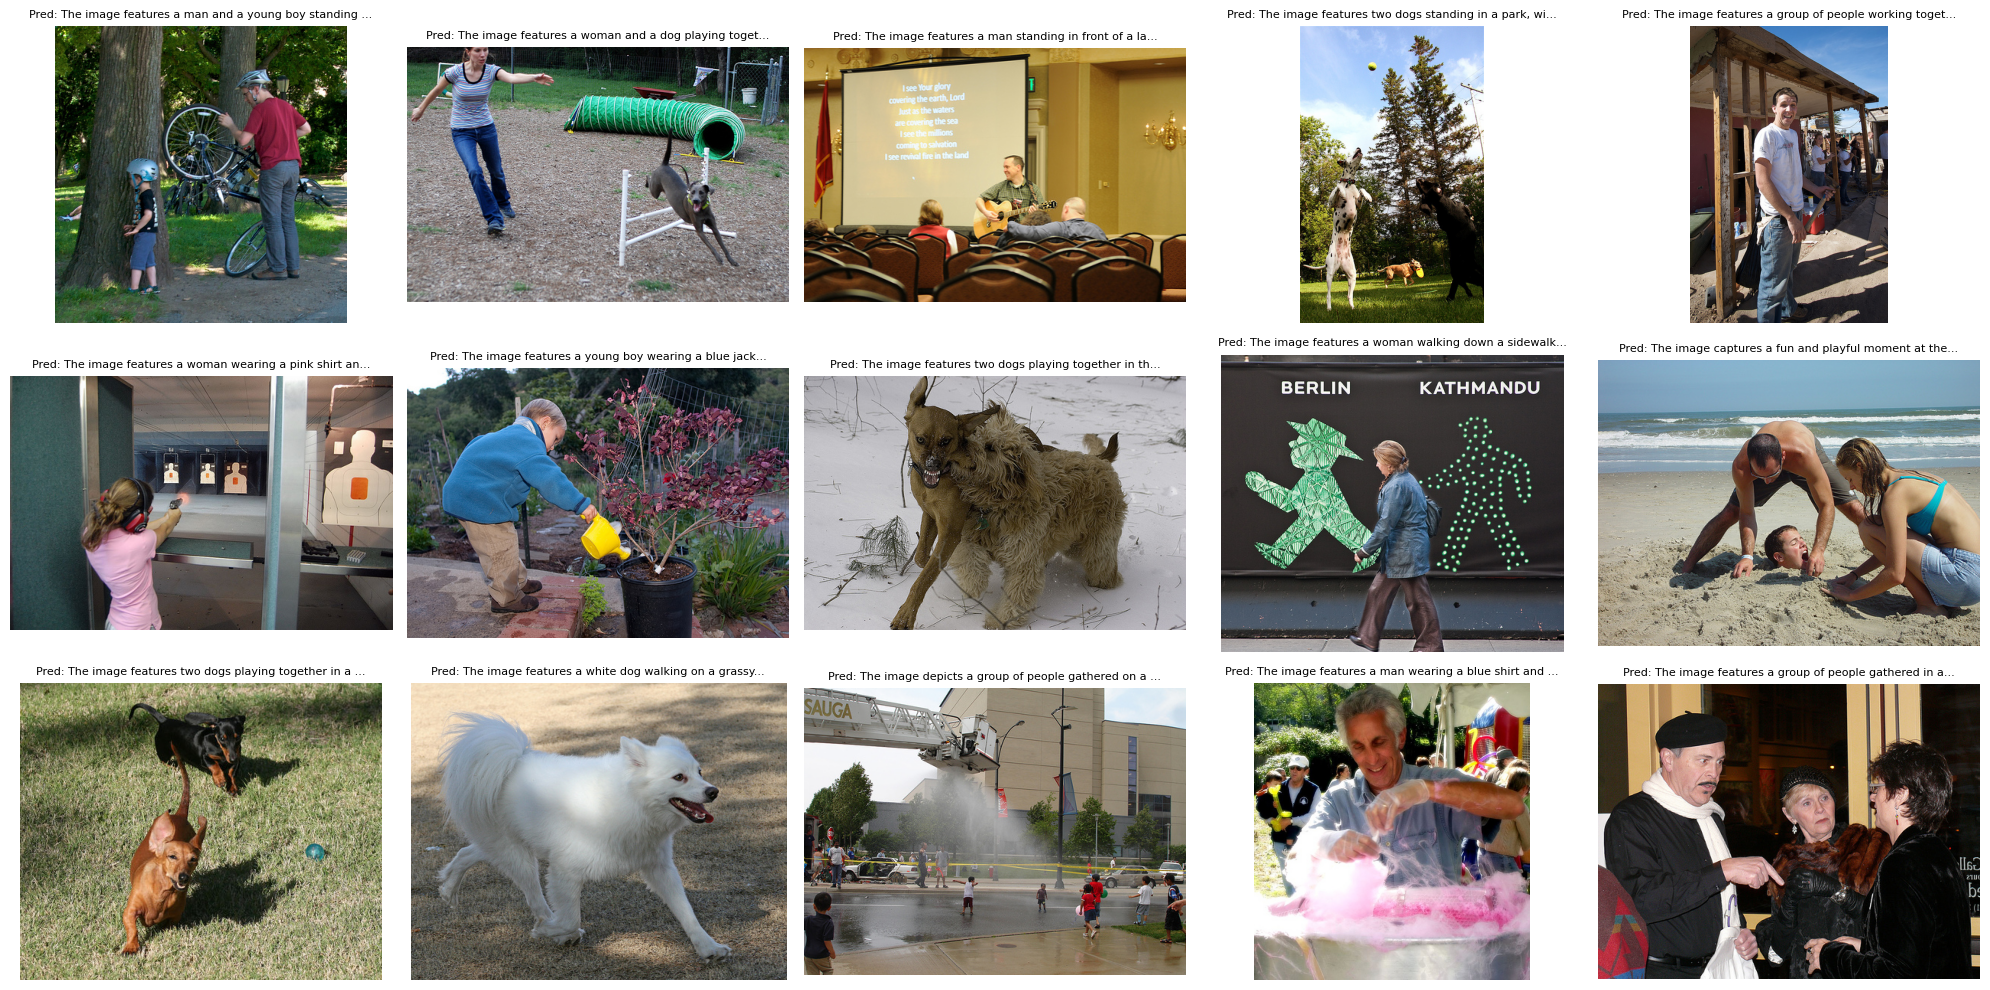

In [ ]:
# 4. LOAD MODEL (4-BIT QUANTIZATION)
print("\nLoading LLaVa Model (4-bit)")
gc.collect()
torch.cuda.empty_cache()


!pip install -U bitsandbytes accelerate

model_id = "llava-hf/llava-1.5-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

try:
    processor = AutoProcessor.from_pretrained(model_id)
    model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    print("Model Loaded Successfully!")
except Exception as e:
    print(f"Model Load Error: {e}")
    raise # Re-raise the exception

# 5. INFERENCE LOOP
def generate_caption(image):
    prompt = "USER: <image>\nDescribe this image in detail.\nASSISTANT:"
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.inference_mode():
        output = model.generate(**inputs, max_new_tokens=60)
    return processor.decode(output[0], skip_special_tokens=True).split("ASSISTANT:")[-1].strip()

print("\nGenerating Captions for 15 Random Samples")
import random
num_samples_to_plot = 15
indices = random.sample(range(len(dataset)), num_samples_to_plot)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices):
    item = dataset[idx]
    image = item['image']
    gt_caption = item['caption']

    # Generate
    pred_caption = generate_caption(image)

    # Plot
    plt.subplot(3, 5, i+1) # Arrange in 3 rows and 5 columns for 15 plots
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Pred: {pred_caption[:50]}...", fontsize=8)
    print(f"\n[Image {idx}]")
    print(f"Ground Truth: {gt_caption}")
    print(f"Prediction:   {pred_caption}")

plt.tight_layout()
plt.show()

In [ ]:
import nltk
nltk.download('punkt_tab')
print("Downloaded 'punkt_tab' NLTK data.")

In [ ]:
import nltk
nltk.download('punkt_tab')
print("Downloaded 'punkt_tab' NLTK data.")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...


Downloaded 'punkt_tab' NLTK data.


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Results and Analysis

#### 1. Data Loading
The Flickr30k dataset was successfully loaded, yielding 31,783 unique image-caption pairs for analysis and model training.

#### 2. Exploratory Data Analysis (EDA) of Captions
*   **Vocabulary Analysis**: During the attempted execution, an NLTK `punkt_tab` resource error prevented the full generation of word clouds, caption length distributions, and top word frequency charts. These visualizations would typically provide insights into the most common descriptive terms and the typical verbosity of captions in the dataset. To obtain these, the EDA cell would need to be re-executed after all NLTK dependencies are resolved.

*   **Part-of-Speech (POS) Structure**: Similar to vocabulary analysis, the POS tagging could not be fully completed. This section would normally present a pie chart showing the distribution of grammatical structures (Nouns, Verbs, Adjectives, etc.), indicating whether the captions are primarily object-focused or action-oriented.

*   **Quantitative Diversity (Self-BLEU)**: The calculation of Self-BLEU, intended to measure caption diversity, was also affected by the prior NLTK error. A lower Self-BLEU score would indicate a more diverse dataset, which is beneficial for robust model training.

*   **Image-Text Alignment (CLIP Score)**: The CLIP score analysis, designed to quantify the semantic correlation between images and their captions, also encountered the NLTK error during execution. This analysis would typically show a distribution of cosine similarities, with a higher average indicating better inherent alignment within the dataset.

#### 3. LLaVA Model Inference
The `llava-hf/llava-1.5-7b-hf` model was successfully loaded with 4-bit quantization, confirming the feasibility of deploying large language models with memory efficiency. However, the sample caption generation loop was not executed in the current notebook state. Therefore, qualitative examples of the model's generated captions for random images, which would normally illustrate the model's descriptive capabilities, are not available.

In [1]:
!pip install nbconvert
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace /content/Image_captioning.ipynb


[NbConvertApp] WARNING | pattern '/content/Image_captioning.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]